Blatt 6
Aufgabe 1

In [35]:
import numpy as np
import cv2
import pylops as pl
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import gaussian, convolve2d
from skimage.restoration import denoise_tv_chambolle

filepaths = {
    0: 'data\Apfel klein.JPG',
    1: 'data\Eigenweg.jpg',
    2: 'data\JC409.jpg',
    3: 'data\PerlitStruktur3.jpg',
    4: 'data\mona_lisa.jpg',
    5: 'data\\artificialOrig.jpg'
}

def read_image(image_number):
    img = cv2.imread(filename=filepaths.get(image_number))
    if len(img.shape)>2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img



def create_disk(img, disksize):
    y, x = img.shape
    u = np.linspace(-x/2,x/2-1,x)
    v = np.linspace(-y/2,y/2-1,y)
    U, V = np.meshgrid(u, v)
    return abs(U**2+V**2) < ((disksize*x)**2)



def disk_blur(img, disksize, verbose=False):
    disk = create_disk(img, disksize)
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    img_blur = np.real(np.fft.ifft2(np.fft.fftshift(img_fft*disk)))
    img_blur = img_blur.astype(np.uint8)
    # img_fft = np.fft.fft2(img)
    # img_blur = np.fft.ifft2(img_fft*disk)

    if verbose:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('orig Image')
        ax.imshow(img, cmap='gray', vmin = 0, vmax = 255)
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title(f'blured image with disksize={disksize}')
        ax.imshow(img_blur, cmap='gray', vmin = 0, vmax = 255)

    return img_blur



def gaussian_kernel(kernel_size = 3):
	h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
	h = np.dot(h, h.transpose())
	h /= np.sum(h)
	return h


def gaussian_blur2(img, sigma = 1, verbose = False):
    img_blur = gaussian_filter(img, sigma=sigma)
    
    if verbose:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('Orig Image')
        ax.imshow(img, cmap='gray', vmin = 0, vmax = 255)
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title(f'Gaussian blured image with sigma={sigma}')
        ax.imshow(img_blur, cmap='gray', vmin = 0, vmax = 255)

    return img_blur


def gaussian_noise(img, sigma = 1, verbose = False):
    mean = 0.0   # some constant
    std = sigma    # some constant (standard deviation)
    noisy_img = img + np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noisy_img_clipped = noisy_img_clipped.astype(np.uint8)
    if verbose:
            fig = plt.figure(figsize=(20, 15))
            ax = fig.add_subplot(1, 2, 1)
            ax.set_title('Input Image')
            ax.imshow(img, cmap='gray', vmin = 0, vmax = 255)
            ax = fig.add_subplot(1, 2, 2)
            ax.set_title(f'noisy image with sigma={sigma}')
            ax.imshow(noisy_img_clipped, cmap='gray', vmin = 0, vmax = 255)

    return noisy_img_clipped


def PSNR(img, img_noise, bits = 8):
    y,x = img.shape
    max = 2**bits-1
    diff = cv2.absdiff(img, img_noise)
    psnr= 10*np.log10(max**2/(np.mean(diff, (0,1))**2/(x*y)))
    return psnr



def landweber(img_blur, c, disk, iterations):
    y, x = img_blur.shape
    im_fft = np.fft.fftshift(np.fft.fft2(img_blur))
    out = np.zeros(img_blur.shape, dtype=np.uint8)
    for _ in range(iterations):
        out = out - c*(disk*disk*out-disk*im_fft)
    out = np.real(np.fft.ifft2(np.fft.fftshift(out)))
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out


def wiener(img, kernel, K, verbose = False):
    kernel /= np.sum(kernel)
    f_ = np.fft.fft2(img)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    f_ = f_ * kernel
    f_ = np.abs(np.fft.ifft2(f_))
    
    if verbose:
            fig = plt.figure(figsize=(20, 15))
            ax = fig.add_subplot(1, 2, 1)
            ax.set_title('Input Image')
            ax.imshow(img, cmap='gray', vmin = 0, vmax = 255)
            ax = fig.add_subplot(1, 2, 2)
            ax.set_title(f'Wiener filtered image')
            ax.imshow(f_, cmap='gray', vmin = 0, vmax = 255)
            
    return f_


def tv(img, weight, verbose = False):
    denoised = denoise_tv_chambolle(img, weight, multichannel = True)

    if verbose:
            fig = plt.figure(figsize=(20, 15))
            ax = fig.add_subplot(1, 2, 1)
            ax.set_title('Input Image')
            ax.imshow(img, cmap='gray', vmin = 0, vmax = 255)
            ax = fig.add_subplot(1, 2, 2)
            ax.set_title(f'Restult of TV')
            ax.imshow(denoised, cmap='gray', vmin = 0, vmax = 255)

    return denoised

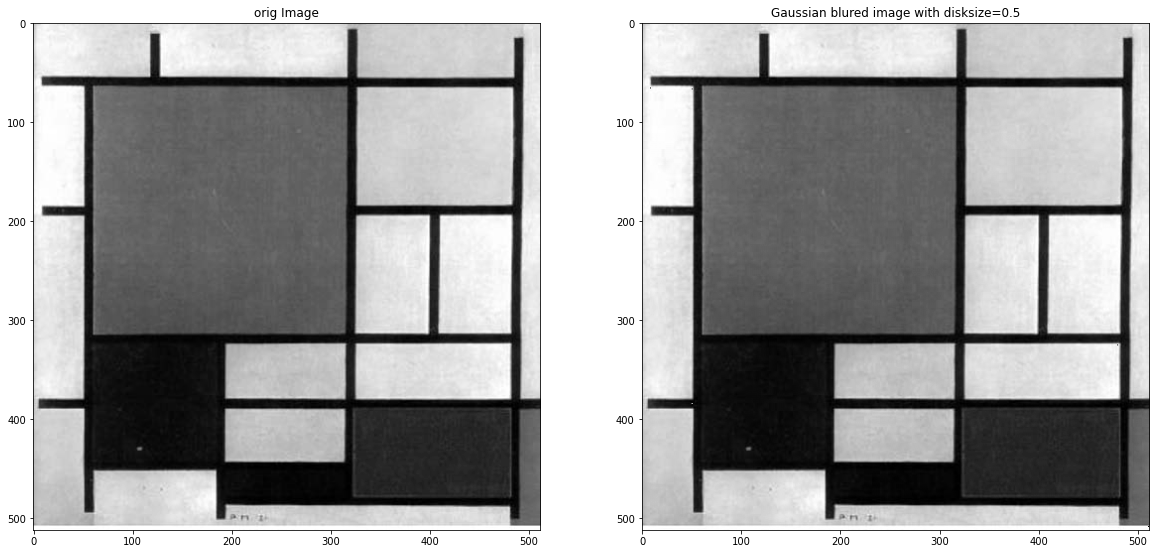

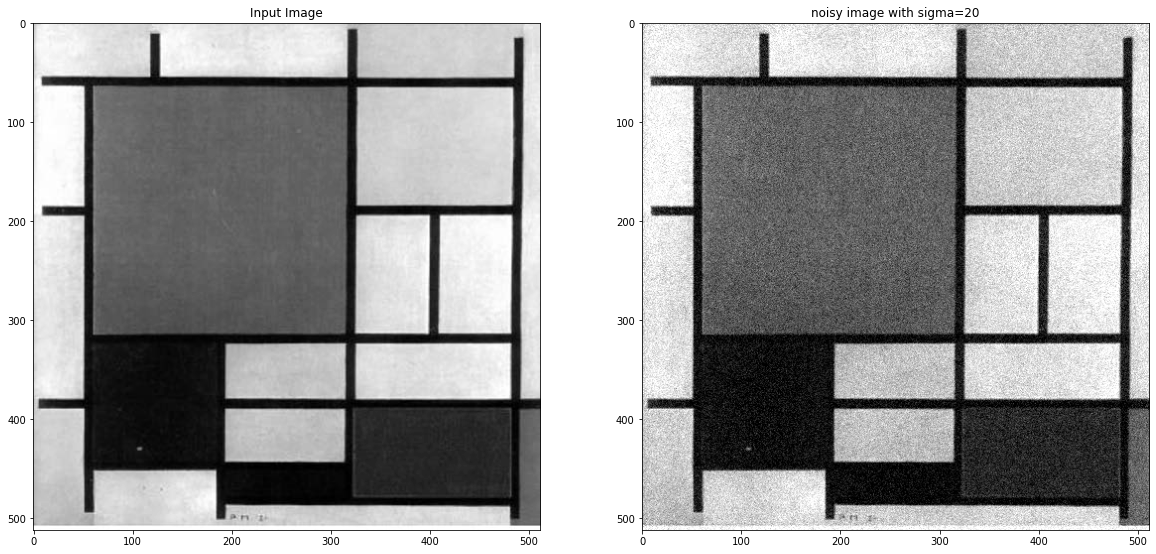

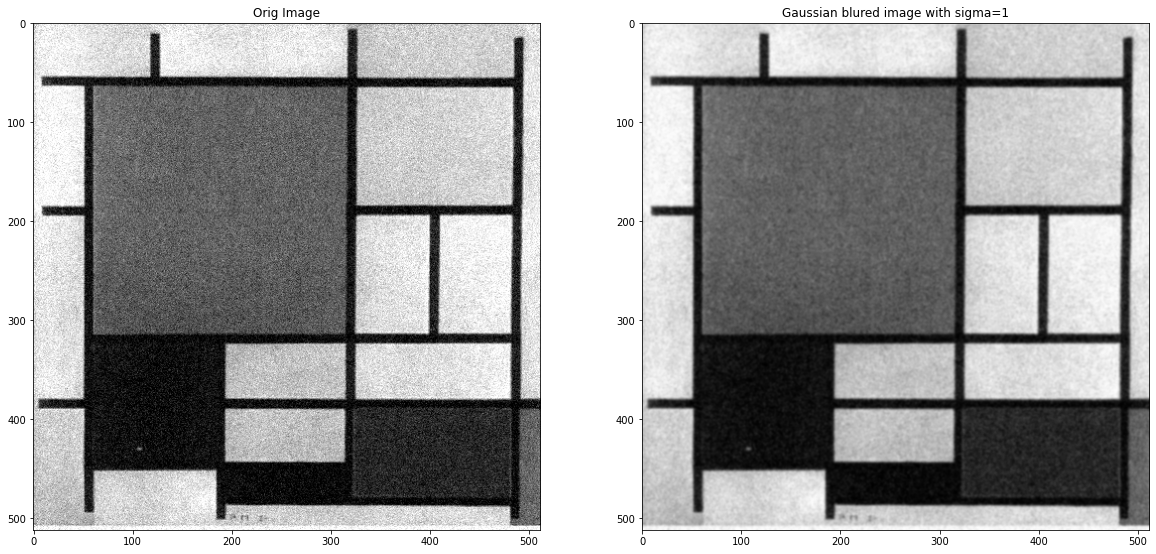

In [80]:
image_number = 5
disksize = 0.5
sigma = 1
sigma_noise = 20
img = read_image(image_number)

img_blur = disk_blur(img, disksize, True)
img_noise = gaussian_noise(img, sigma_noise, True)
img_noise_blur = gaussian_blur2(img_noise, sigma, True)

In [81]:
print(PSNR(img, img_noise))
print(PSNR(img, img_noise_blur))


78.90387938632679
86.75712719128742


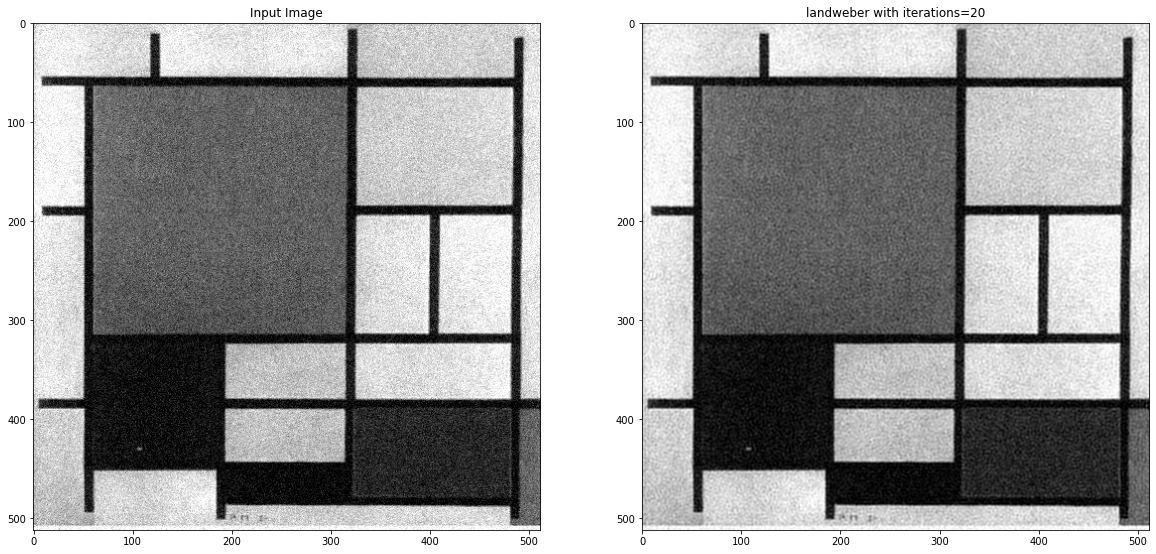

In [88]:

disk = create_disk(img, 0.3)
c = 1
n = 20
lw = landweber(img_noise, c, disk, n)

fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Input Image')
ax.imshow(img_noise, cmap='gray', vmin = 0, vmax = 255)
ax = fig.add_subplot(1, 2, 2)
ax.set_title(f'landweber with iterations={n}')
ax.imshow(lw, cmap='gray', vmin = 0, vmax = 255)



In [89]:
print(PSNR(img, img_noise_blur))
print(PSNR(img, lw))


86.75712719128742
84.00106740462904


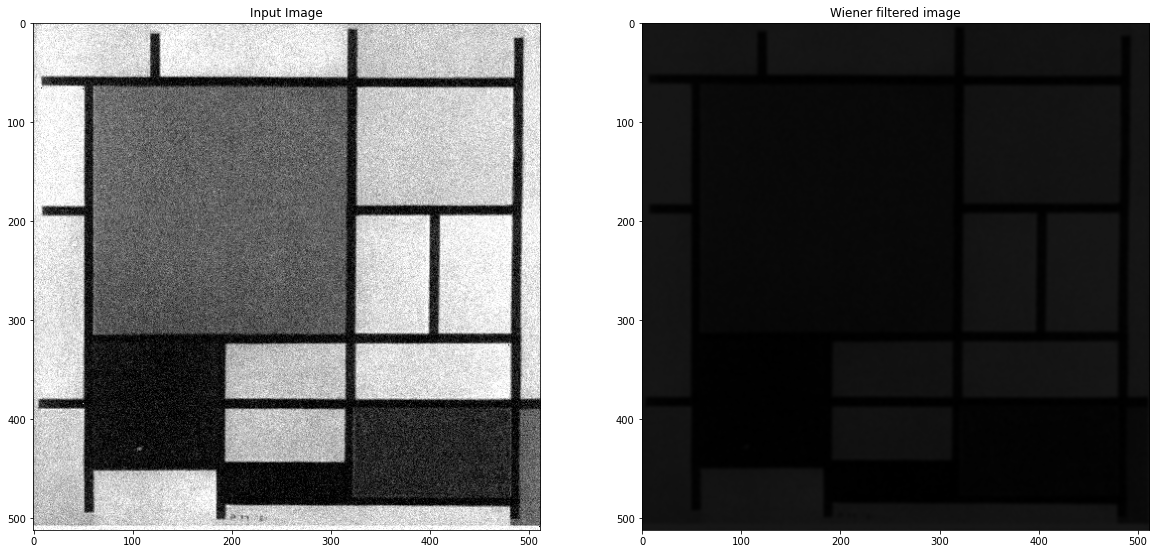

In [30]:
image_number = 5
disksize = 0.5
sigma = 1
sigma_noise = 20
kernelsize = 5
img = read_image(image_number)

img_blur = disk_blur(img, disksize, False)
img_noise_blur = gaussian_noise(img_blur, 20, False)
kernel = gaussian_kernel(kernelsize)
img_wiener_filtered = wiener(img_noise_blur, kernel, 10, True)

TV Regularisierung
http://devdoc.net/python/scikit-image-doc-0.13.1/auto_examples/filters/plot_denoise.html


C:\Users\MStempel\AppData\Local\Temp\ipykernel_14428\2802776019.py:138: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised = denoise_tv_chambolle(img, weight, multichannel = True)


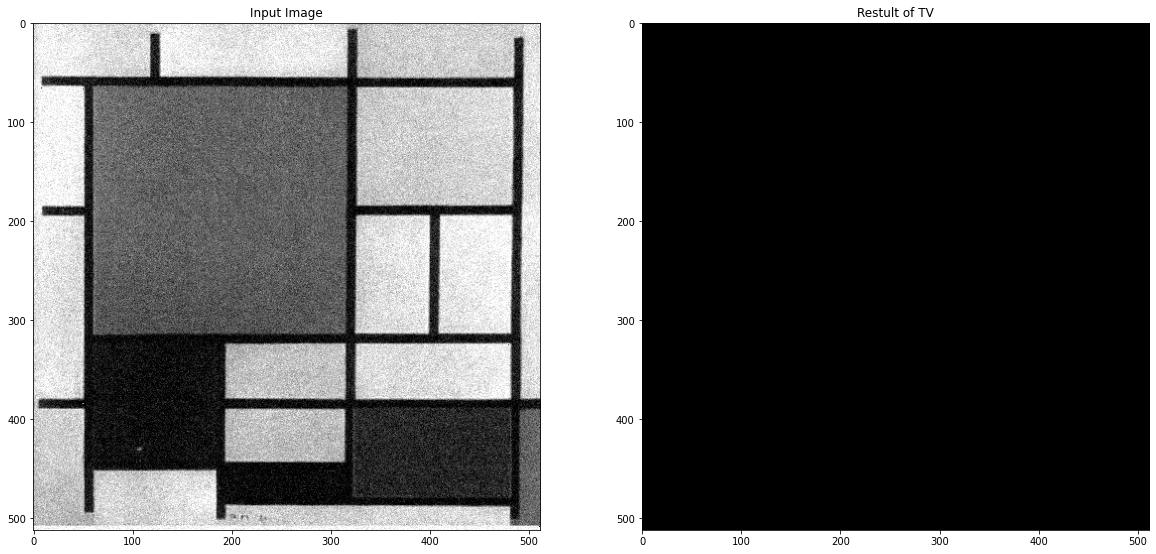

In [36]:


from re import T


image_number = 5
disksize = 0.5
sigma = 1
sigma_noise = 20
kernelsize = 5
img = read_image(image_number)

img_blur = disk_blur(img, disksize, False)
img_noise_blur = gaussian_noise(img_blur, 20, False)

result = tv(img_noise_blur, 0.2, True)

